In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout,Conv2D,BatchNormalization,LeakyReLU,Concatenate,UpSampling2D,MaxPool2D,Add
from keras import backend as K
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
NUM_CLASSES = 26
NUM_ANCHORS = 3
constant_anchors = {
    #"52":[[10,13], [16,30], [33,23]],
    26:[[7.90196078,5.824],[ 17.46078431,16.19298246],[ 43.03448105,39.25490196]],
    13:[[ 95.50221204,73.70000839],[145.99999905,161.99999809],[255.31603053,238.99232006]],
}

ANCHORS = np.array([[7.90196078,5.824],[ 17.46078431,16.19298246],[ 43.03448105,39.25490196],[ 95.50221204,73.70000839],[145.99999905,161.99999809],[255.31603053,238.99232006]])

ANCHOR_INDECES = {
    26:[0,1,2],
    13:[3,4,5],
}

In [40]:
import keras
import keras.layers as layers
import keras.backend as K
import tensorflow as tf


class Mish(layers.Layer):
    """Mish activation"""

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))


# this GroupFeature can not work because it cause some bugs:
# 'number of input channels does not match corresponding dimension of filter, 32!=64'
# class GroupFeature(layers.Layer):
#
#     def __init__(self, num_splits, **kwargs):
#         super(GroupFeature, self).__init__(**kwargs)
#         self.num_splits = num_splits
#
#     def call(self, inputs, **kwargs):
#         return tf.split(inputs, num_or_size_splits=self.num_splits, axis=-1)[0]


def conv_bn_activation(inputs,
                       filters,
                       filter_size,
                       downsample=False,
                       activation='leaky'):
    """yolo4-tiny is using leaky activation in source code"""

    assert activation in ['mish', 'leaky'], 'activation must be leaky or mish'

    if downsample:
        inputs = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(inputs)
        padding = 'valid'
        strides = 2
    else:
        padding = 'same'
        strides = 1

    x = layers.Conv2D(filters=filters,
                      kernel_size=filter_size,
                      strides=strides,
                      padding=padding,
                      use_bias=False,
                      kernel_regularizer=keras.regularizers.l2(0.0005),
                      kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
                      bias_initializer=keras.initializers.constant(0.0))(inputs)
    x = layers.BatchNormalization()(x)
    if activation == 'mish':
        x = Mish()(x)
    else:
        x = layers.LeakyReLU(negative_slope=0.1)(x)

    return x


def csp_darknet_tiny(inputs):
    x = conv_bn_activation(inputs, 32, 3, downsample=True)
    x = conv_bn_activation(x, 64, 3, downsample=True)
    x = conv_bn_activation(x, 64, 3)

    route = x

    # TODO: the index is 1 in source code so i change 0 to 1
    x_group = layers.Lambda(lambda y: tf.split(y, num_or_size_splits=2, axis=-1)[1])(x)
    x_group = conv_bn_activation(x_group, 32, 3)
    route1 = x_group
    x_group = conv_bn_activation(x_group, 32, 3)
    x_group = layers.Concatenate()([x_group, route1])
    x_group = conv_bn_activation(x_group, 64, 1)
    x_group = layers.Concatenate()([route, x_group])
    x_group = layers.MaxPool2D(pool_size=2, padding='same')(x_group)

    x = conv_bn_activation(x_group, 128, 3)
    route = x

    # TODO: the index is 1 in source code so i change 0 to 1
    x_group = layers.Lambda(lambda y: tf.split(y, num_or_size_splits=2, axis=-1)[1])(x)
    x_group = conv_bn_activation(x_group, 64, 3)
    route1 = x_group
    x_group = conv_bn_activation(x_group, 64, 3)
    x_group = layers.Concatenate()([x_group, route1])
    x_group = conv_bn_activation(x_group, 128, 1)
    x_group = layers.Concatenate()([route, x_group])
    x_group = layers.MaxPool2D(pool_size=2, strides=2, padding='same')(x_group)

    x = conv_bn_activation(x_group, 256, 3)
    route = x

    # TODO: the index is 1 in source code so i change 0 to 1
    x_group = layers.Lambda(lambda y: tf.split(y, num_or_size_splits=2, axis=-1)[1])(x)
    x_group = conv_bn_activation(x_group, 128, 3)
    route1 = x_group
    x_group = conv_bn_activation(x_group, 128, 3)
    x_group = layers.Concatenate()([x_group, route1])
    x_group = conv_bn_activation(x_group, 256, 1)

    C4 = x_group

    x_group = layers.Concatenate()([route, x_group])
    x_group = layers.MaxPool2D(pool_size=2, strides=2)(x_group)

    C5 = conv_bn_activation(x_group, 512, 3)

    return C4, C5


def yolo4_tiny(inputs, num_anchors, num_classes):

    C4, C5 = csp_darknet_tiny(inputs)

    x = conv_bn_activation(C5, 256, 1)
    output_C5 = conv_bn_activation(x, 512, 3)
    output_C5 = layers.Conv2D(num_anchors * (num_classes + 5),
                              1,
                              kernel_regularizer=keras.regularizers.l2(5e-4),
                              kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
                              bias_initializer=keras.initializers.constant(0.0))(output_C5)

    x_upsample = conv_bn_activation(x, 128, 1)
    x_upsample = layers.UpSampling2D()(x_upsample)
    x_concat = layers.Concatenate()([x_upsample, C4])

    output_C4 = conv_bn_activation(x_concat, 256, 3)
    output_C4 = layers.Conv2D(num_anchors * (5 + num_classes),
                              1,
                              kernel_regularizer=keras.regularizers.l2(5e-4),
                              kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
                              bias_initializer=keras.initializers.constant(0.0))(output_C4)

    print(output_C4.shape, output_C5.shape)
    model = keras.Model(inputs, [output_C5, output_C4])

    return model

inputs = keras.Input(shape=(416, 416, 3))
backbone = yolo4_tiny(inputs, num_anchors=NUM_ANCHORS, num_classes=NUM_CLASSES)
backbone.summary()


(None, 26, 26, 93) (None, 13, 13, 93)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 417, 417,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 208, 208,  │        864 │ zero_padding2d_4… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 208, 208,  │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_38      │ (None, 208, 208,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 209, 209,  │          0 │ leaky_re_lu_38[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 104, 104,  │     18,432 │ zero_padding2d_5… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_39      │ (None, 104, 104,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 104, 104,  │     36,864 │ leaky_re_lu_39[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_40      │ (None, 104, 104,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 104, 104,  │          0 │ leaky_re_lu_40[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 104, 104,  │      9,216 │ lambda_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        128 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_41      │ (None, 104, 104,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 104, 104,  │      9,216 │ leaky_re_lu_41[0

 Total params: 5,938,074 (22.65 MB)

 Trainable params: 5,931,866 (22.63 MB)

 Non-trainable params: 6,208 (24.25 KB)

In [41]:
PHOTO_SIZE = 416

tf.config.run_functions_eagerly(True)
bce = tf.keras.losses.BinaryCrossentropy()
cce = tf.keras.losses.CategoricalCrossentropy()

def iou_vectorized(boxes1, boxes2):
    """
    Compute IoU between every pair of boxes in boxes1 and boxes2.
    boxes1: (N, 4) [x_center, y_center, w, h]
    boxes2: (M, 4) [x_center, y_center, w, h]
    Returns:
      iou: (N, M) tensor with IoU values.
    """
    
    boxes1_corners = box_centers_to_corners(boxes1)  # (N,4)
    boxes2_corners = box_centers_to_corners(boxes2)  # (M,4)

    # Expand dims to broadcast pairwise
    boxes1_exp = tf.expand_dims(boxes1_corners, 1)  # (N,1,4)
    boxes2_exp = tf.expand_dims(boxes2_corners, 0)  # (1,M,4)

    # Intersection coordinates
    inter_xmin = tf.maximum(boxes1_exp[..., 0], boxes2_exp[..., 0])  # (N,M)
    inter_ymin = tf.maximum(boxes1_exp[..., 1], boxes2_exp[..., 1])  # (N,M)
    inter_xmax = tf.minimum(boxes1_exp[..., 2], boxes2_exp[..., 2])  # (N,M)
    inter_ymax = tf.minimum(boxes1_exp[..., 3], boxes2_exp[..., 3])  # (N,M)

    # Intersection dimensions
    inter_w = tf.maximum(inter_xmax - inter_xmin, 0)
    inter_h = tf.maximum(inter_ymax - inter_ymin, 0)
    inter_area = inter_w * inter_h  # (N,M)

    # Areas of boxes
    area1 = (boxes1_corners[..., 2] - boxes1_corners[..., 0]) * (boxes1_corners[..., 3] - boxes1_corners[..., 1])  # (N,)
    area2 = (boxes2_corners[..., 2] - boxes2_corners[..., 0]) * (boxes2_corners[..., 3] - boxes2_corners[..., 1])  # (M,)

    area1 = tf.expand_dims(area1, 1)  # (N,1)
    area2 = tf.expand_dims(area2, 0)  # (1,M)

    union_area = area1 + area2 - inter_area  # (N,M)

    iou = tf.where(union_area > 0, inter_area / union_area, tf.zeros_like(inter_area))

    return iou

def box_centers_to_corners(boxes):
    """
    Convert [x_center, y_center, w, h] to [x_min, y_min, x_max, y_max].
    boxes: (N, 4) tensor.
    Returns: (N, 4) tensor.
    """
    x_c, y_c, w, h = tf.split(boxes, 4, axis=-1)  # each (N,1)
    x_min = x_c - w / 2
    y_min = y_c - h / 2
    x_max = x_c + w / 2
    y_max = y_c + h / 2
    return tf.concat([x_min, y_min, x_max, y_max], axis=-1)  # (N,4)

def ciou(boxes1, boxes2, eps=1e-7):
    """
    Calculate CIoU between boxes1 and boxes2

    boxes1, boxes2: [..., 4], format = [x_center, y_center, width, height], normalized coords (0~1)
    returns: tensor [...], CIoU values
    """
    boxes1 = tf.convert_to_tensor(boxes1)
    boxes2 = tf.convert_to_tensor(boxes2)

    # Convert centers to corners: (x1, y1, x2, y2)
    boxes1_x1 = boxes1[..., 0] - boxes1[..., 2] / 2
    boxes1_y1 = boxes1[..., 1] - boxes1[..., 3] / 2
    boxes1_x2 = boxes1[..., 0] + boxes1[..., 2] / 2
    boxes1_y2 = boxes1[..., 1] + boxes1[..., 3] / 2

    boxes2_x1 = boxes2[..., 0] - boxes2[..., 2] / 2
    boxes2_y1 = boxes2[..., 1] - boxes2[..., 3] / 2
    boxes2_x2 = boxes2[..., 0] + boxes2[..., 2] / 2
    boxes2_y2 = boxes2[..., 1] + boxes2[..., 3] / 2

    # Intersection box
    inter_x1 = tf.maximum(boxes1_x1, boxes2_x1)
    inter_y1 = tf.maximum(boxes1_y1, boxes2_y1)
    inter_x2 = tf.minimum(boxes1_x2, boxes2_x2)
    inter_y2 = tf.minimum(boxes1_y2, boxes2_y2)

    inter_w = tf.maximum(inter_x2 - inter_x1, 0)
    inter_h = tf.maximum(inter_y2 - inter_y1, 0)
    inter_area = inter_w * inter_h

    # Areas
    area1 = (boxes1_x2 - boxes1_x1) * (boxes1_y2 - boxes1_y1)
    area2 = (boxes2_x2 - boxes2_x1) * (boxes2_y2 - boxes2_y1)

    union_area = area1 + area2 - inter_area + eps
    #inter_area = tf.cast(inter_area, tf.float32)
    #union_area = tf.cast(union_area, tf.float32)

    iou = tf.where(
        tf.not_equal(union_area, 0.0),
        inter_area / union_area,
        tf.constant(0.0, dtype=tf.float32)
    )

    # center distance squared
    center_dist = tf.square(boxes1[..., 0] - boxes2[..., 0]) + tf.square(boxes1[..., 1] - boxes2[..., 1])

    # smallest enclosing box
    enclose_x1 = tf.minimum(boxes1_x1, boxes2_x1)
    enclose_y1 = tf.minimum(boxes1_y1, boxes2_y1)
    enclose_x2 = tf.maximum(boxes1_x2, boxes2_x2)
    enclose_y2 = tf.maximum(boxes1_y2, boxes2_y2)
    enclose_w = enclose_x2 - enclose_x1
    enclose_h = enclose_y2 - enclose_y1
    c2 = tf.square(enclose_w) + tf.square(enclose_h) + eps

    # aspect ratio consistency
    w1 = boxes1[..., 2]
    h1 = boxes1[..., 3]
    w2 = boxes2[..., 2]
    h2 = boxes2[..., 3]

    v = (4 / (3.14159265 ** 2)) * tf.square(tf.math.atan(w2 / (h2 + eps)) - tf.math.atan(w1 / (h1 + eps)))
    with tf.device('/CPU:0'):  # to avoid potential GPU precision errors
        alpha = v / (1 - iou + v + eps)

    ciou = iou - (center_dist / c2) - alpha * v

    return ciou

def focal_bce(y_true, y_pred, gamma=3.0, alpha=0.25):
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    modulating_factor = tf.pow(1.0 - p_t, gamma)
    alpha_weight = y_true * alpha + (1 - y_true) * (1 - alpha)
    return alpha_weight * modulating_factor * bce

def vectorized_what_grid_cell_it_resides(true_BBs, resolution):
    """
    true_BBs: tf.Tensor of shape (N, 4), each row = [x, y, w, h]
    resolution: int, e.g., 13 or 26
    
    Returns:
        x_cell: tf.Tensor, shape (N,), int32
        y_cell: tf.Tensor, shape (N,), int32
        normalized_BB: tf.Tensor, shape (N, 4), float32
            Each row: [x_offset_in_cell, y_offset_in_cell, w, h]
    """
    pixels_per_grid = PHOTO_SIZE // resolution  # scalar int

    x = true_BBs[:, 0]  # shape (N,)
    y = true_BBs[:, 1]  # shape (N,)
    w = true_BBs[:, 2]  # shape (N,)
    h = true_BBs[:, 3]  # shape (N,)

    x_cell = tf.cast(x // pixels_per_grid, tf.int32)  # (N,)
    y_cell = tf.cast(y // pixels_per_grid, tf.int32)  # (N,)

    x_offset = x % pixels_per_grid  # (N,)
    y_offset = y % pixels_per_grid  # (N,)

    normalized_BB = tf.stack([x_offset, y_offset, w, h], axis=1)  # (N,4)

    return x_cell, y_cell, normalized_BB

def normalize_yolo_output(y_pred):
    """
    y_pred: (batch, S, S, 3, 5 + C)
    anchors: (3, 2) — anchor box sizes (width, height) in pixels
    grid_size: int — S = 13 or 26 typically

    Returns:
        Tensor of shape (batch, S, S, 3, 5 + C) with:
        - objectness: sigmoid
        - class scores: softmax
    """
    grid_size = y_pred.shape[1]
    anchors = tf.convert_to_tensor(constant_anchors[grid_size], dtype=tf.float32)  # (3, 2)

    # Ensure anchor shape is (1, 1, 1, 3, 2) to broadcast
    anchors = tf.reshape(anchors, (1, 1, 1, NUM_ANCHORS, 2))

    # Slice components
    tx = tf.sigmoid(y_pred[..., 0]) * (PHOTO_SIZE // grid_size)
    ty = tf.sigmoid(y_pred[..., 1]) * (PHOTO_SIZE // grid_size)
    tw = tf.exp(y_pred[..., 2]) * anchors[..., 0]
    th = tf.exp(y_pred[..., 3]) * anchors[..., 1]
    obj = tf.sigmoid(y_pred[..., 4])
    cls = tf.nn.softmax(y_pred[..., 5:], axis=-1)

    # Stack normalized values
    bbox = tf.stack([tx, ty, tw, th, obj], axis=-1)  # shape: (batch, S, S, 3, 5)
    out = tf.concat([bbox, cls], axis=-1)           # shape: (batch, S, S, 3, 5 + C)

    return out

@tf.function
def yolo_loss_single_head(y_true, y_pred,
                            lambda_coord = 30.0,
                            lambda_obj = 20.0,
                            lambda_noobj = 0.5,
                            lambda_class = 1.0):
    """
    y_true: (batch, MAX_BOUNDING_BOXES, 5 + C)
    y_pred: (batch, S, S, B, 5 + C)
    anchors: Tensor shape (B, 2) → width, height
    """

    resolution = y_pred.shape[1]
    batch_size = tf.shape(y_true)[0]

    total_loss = 0
    position_loss = 0
    obj_confidence_loss = 0
    noobj_confidence_loss = 0
    clasification_loss = 0

    #print("head type",resolution)

    normalized_pred = normalize_yolo_output(y_pred)#get unsigmoided stuff and tx,ty,tw,th instead of tx,ty,w,h but return this 

    for b in tf.range(batch_size):
        mask = tf.Variable(tf.ones((resolution, resolution, NUM_ANCHORS), dtype=tf.float32))
        true_boxes = y_true[b]
        confidence_mask = tf.greater(true_boxes[:,4], 0)
        true_boxes = tf.boolean_mask(true_boxes, confidence_mask)
        dimensions = tf.cast(true_boxes[:, :4], tf.float32)
        classifications = tf.cast(true_boxes[:, 5:], tf.float32)

        x_cell, y_cell, normalized_true_BB = vectorized_what_grid_cell_it_resides(dimensions, resolution)

        for i in tf.range(tf.shape(true_boxes)[0]):
            preds = normalized_pred[b, x_cell[i], y_cell[i], :, :4]

            ious = iou_vectorized(tf.expand_dims(normalized_true_BB[i], 0), preds)  # (NUM_ANCHORS,)
            ious = tf.squeeze(ious, axis=0)

            best_ind = tf.argmax(ious, axis=-1)
            best_ind = tf.cast(best_ind, tf.int32)

            best_BB = normalized_pred[b, x_cell[i], y_cell[i], best_ind, :4]
            best_confidence = normalized_pred[b, x_cell[i], y_cell[i], best_ind, 4]
            best_clasification = normalized_pred[b, x_cell[i], y_cell[i], best_ind, 5:]

            # Calculate losses
            #print("predicted iou",ious[best_ind])
            #print("best confidence predicted",best_confidence)
            position_loss += tf.constant(1.0, dtype=tf.float32) - ciou(normalized_true_BB[i], best_BB)
            #print("confidence loss = ",tf.keras.backend.binary_crossentropy(tf.ones_like(ious[best_ind]), tf.reshape(best_confidence, (1,))))
            obj_confidence_loss += tf.keras.backend.binary_crossentropy(ious[best_ind], tf.reshape(best_confidence, (1,)))
            clasification_loss += cce(tf.expand_dims(classifications[i], 0), tf.expand_dims(best_clasification, 0))

            pred_boxes = normalized_pred[b, :, :, :, :4]
            pred_boxes_flat = tf.reshape(pred_boxes, [-1, 4])

            true_box = tf.expand_dims(true_boxes[i,:4],axis=0)

            ious = iou_vectorized(true_box, pred_boxes_flat)  # output shape (1, res*res*NUM_ANCHORS)
            ious = tf.squeeze(ious, axis=0)  # shape (res*res*NUM_ANCHORS)

            iou_mask = ious > 0.5  # boolean mask (res*res*NUM_ANCHORS)

            mask_flat = tf.reshape(mask, [-1])  # flatten mask (res*res*NUM_ANCHORS)
            mask_flat = tf.where(iou_mask, 0.0, mask_flat)  # zero where iou_mask true
            mask.assign(tf.reshape(mask_flat, mask.shape))  # reshape back and assign
            mask[x_cell[i], y_cell[i], best_ind].assign(0.0)

        #TO DO harsher penalty when the model is predicting ious under a threshold prob 0.4
        pred_confidences = normalized_pred[b, :, :, :, 4]  # shape (res, res, NUM_ANCHORS)
        zeros = tf.zeros_like(pred_confidences)
        bce_losses = tf.keras.backend.binary_crossentropy(zeros, pred_confidences)
        weighted_losses = mask * bce_losses

        noobj_confidence_loss += tf.reduce_sum(weighted_losses)

    
    #print("position_loss",position_loss / tf.cast(batch_size, tf.float32))
    #print("obj_confidence_loss",obj_confidence_loss / tf.cast(batch_size, tf.float32))
    #print("noobj_confidence_loss",noobj_confidence_loss / tf.cast(batch_size, tf.float32))
    #print("clasification_loss",clasification_loss / tf.cast(batch_size, tf.float32))

    total_loss = (position_loss * lambda_coord + 
              obj_confidence_loss * lambda_obj +
              noobj_confidence_loss * lambda_noobj +
              clasification_loss * lambda_class)

    return total_loss / tf.cast(batch_size, tf.float32)

def yolo_multihead_loss(y_trues, y_preds):
    """
    y_trues: (batch, 2 , MAX_BOUNDING_BOXES, 5 + C)
    y_preds: list of (nr heads,batch, S, S, B*(5 + C)) tensors
    """
    y_preds_13 = tf.cast(y_preds[0], tf.float32)
    y_preds_26 = tf.cast(y_preds[1], tf.float32)
    batch_size = tf.shape(y_trues)[0]

    y_preds_13 = tf.reshape(y_preds_13, (batch_size, 13, 13, NUM_ANCHORS, 5 + NUM_CLASSES))
    y_preds_26 = tf.reshape(y_preds_26, (batch_size, 26, 26, NUM_ANCHORS, 5 + NUM_CLASSES))
    
    y_13_true = y_trues[:, 0, :, :]
    y_26_true = y_trues[:, 1, :, :]

    total_loss = 0.0

    loss_13 = yolo_loss_single_head(y_13_true, y_preds_13)
    loss_26 = yolo_loss_single_head(y_26_true, y_preds_26)

    total_loss = loss_13 + loss_26

    return tf.cast(total_loss , tf.float32)



In [42]:
class YOLOMultiHeadModel(tf.keras.Model):
    def __init__(self, backbone_model, loss_fn):
        super(YOLOMultiHeadModel, self).__init__()
        self.backbone = backbone_model
        self.loss_fn = loss_fn
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        return self.backbone(inputs, training=training)

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_fn(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        grads_and_vars = []
        for grad, var in zip(gradients, self.trainable_variables):
            if grad is None:
                tf.print(f"No gradients for variable: {var.name}")
            else:
                grads_and_vars.append((grad, var))
        self.optimizer.apply_gradients(grads_and_vars)
        self.loss_tracker.update_state(loss)
        tf.print("\n")
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        images, labels = data
        predictions = self(images, training=False)
        loss = self.loss_fn(labels, predictions)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]
    
model = YOLOMultiHeadModel(backbone, loss_fn=yolo_multihead_loss)

In [60]:
model.load_weights("./checkpoints/epoch_25.h5")

(1, 416, 416, 3)


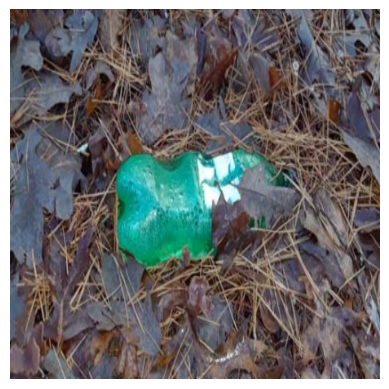

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def decode_predictions(pred, conf_thresh=0.2):
    batch_size, grid, _, anchors, channels = pred.shape
    pred = pred[0].numpy()
    boxes = []
    pixels_per_grid = 416 // grid
    for i in range(grid):
        for j in range(grid):
            for k in range(anchors):
                obj_score = pred[i, j, k, 4]
                if obj_score > conf_thresh:
                    bx, by, bw, bh = pred[i, j, k, 0:4]
                    class_probs = pred[i, j, k, 5:]
                    class_id = np.argmax(class_probs)
                    score = obj_score * class_probs[class_id]
                    boxes.append([bx + pixels_per_grid * i, by + pixels_per_grid * j, bw, bh, score, class_id])
    return boxes

def preprocess_image(image_path, img_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_size, img_size))
    image = image / 255.0  # normalize
    return tf.expand_dims(image, axis=0)
img_size = 416  # or whatever your model uses
image_tensor = preprocess_image("./litter.jpg", img_size)

preds = model(image_tensor, training=False)
preds = [
    normalize_yolo_output(tf.reshape(preds[0],(1, 13, 13, NUM_ANCHORS, 5 + NUM_CLASSES))),
    normalize_yolo_output(tf.reshape(preds[1],(1, 26, 26, NUM_ANCHORS, 5 + NUM_CLASSES)))
    ]
grid_size_13 = preds[0]
grid_size_26 = preds[1]

filtered_grid_size_13 = decode_predictions(grid_size_13)
filtered_grid_size_26 = decode_predictions(grid_size_26)

def convert_box(cx, cy, w, h, img_w, img_h):
    x = int((cx - w / 2))
    y = int((cy - h / 2))
    w = int(w)
    h = int(h)
    return x, y, w, h

def plot_boxes(image, boxes, class_names=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box in boxes:
        cx, cy, w, h, score, class_id = box
        x, y, bw, bh = convert_box(cx, cy, w, h, image.shape[1], image.shape[0])
        print(x, y, bw, bh)
        rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        #label = f"{class_names[int(class_id)] if class_names else class_id}: {score:.2f}"
        #ax.text(x, y, label, color='white', fontsize=10,
        #        bbox=dict(facecolor='black', edgecolor='none', alpha=0.5))
    
    plt.axis('off')

print(image_tensor.shape)
plot_boxes(tf.squeeze(image_tensor, axis=0),filtered_grid_size_13)